In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
from sklearn.cluster  import KMeans
from tqdm import tqdm
import time
from matplotlib.colors import ListedColormap

In [3]:
def save_as_raster(image, src_path, output_filename) :

    image = np.array(image)
    
    with rasterio.open(src_path)  as data:
        crs= data.crs
        bounds = data.bounds
        count= data.count
        resolution_x = data.res[0]  
        resolution_y = data.res[1]
        transform = data.transform
        dtype =image.dtype

    with rasterio.open(output_filename, 'w', driver='GTiff', width=image.shape[1], height=image.shape[0], count=count, transform=transform, crs=crs, bounds=bounds, dtype=dtype) as dst:
        dst.write(image, 1)
    print("Raster created as :", output_filename)

In [4]:
def kmeans_df(df_file, kvalue, output_filename) :
    df=pd.read_csv(df_file)
    dfa = df.iloc[:, 2:]

    kmeans=KMeans(n_clusters=20).fit(dfa)

    #affecter les cluster à la varialb e labels
    labels=kmeans.labels_

    #créer un dataset qui contient les valeurs de dfa_std
    new_df=pd.DataFrame(data=df)

    #rajouter les labels à mon dataset dfa_std
    new_df['labels_kmeans']=labels

    # Enregistrement du DataFrame au format CSV
    new_df.to_csv(output_filename, index=False)

    return new_df

In [5]:
def create_kmeans_image(df_file, path) :
    df=pd.read_csv(df_file)
    dfa = df.iloc[:, [0, 1, -1]]
    
    with rasterio.open(path) as data :
        band1 = data.read(1)
        largeur = band1.shape[1]
        hauteur = band1.shape[0]

    # Créer une matrice vide pour l'image
    image = [[0 for _ in range(largeur)] for _ in range(hauteur)]

# Remplir la matrice avec les valeurs du DataFrame
    for index, row in dfa.iterrows():
        x, y, valeur = row['coord_x'], row['coord_y'], row[-1]
        image[y][x] = valeur  

    return image

In [10]:
def create_dataset(image_paths, dataframe_filename) :
    with rasterio.open(image_paths[0]) as data :
        band1 = data.read(1)
        largeur = band1.shape[1]
        hauteur = band1.shape[0]

    coord_x =[]
    coord_y =[]

    for x in range(largeur):
        for y in range(hauteur):
            coord_x.append(x)
            coord_y.append(y)
    data = {
        'coord_x': coord_x,
        'coord_y': coord_y,
            }

    # Création du DataFrame à partir du dictionnaire
    df = pd.DataFrame(data)

    for path in image_paths :
        values = []
        with rasterio.open(path) as src :
            band1 = src.read(1)
            for x in range(band1.shape[1]) :
                for y in range(band1.shape[0]):
                    value = band1[y,x]
                    values.append(value)
        df[path] = values


    df.to_csv(dataframe_filename, index=False)

    return df  

In [6]:
paths = [
    'temp1_LH.tif',
    'temp2_LH.tif',
    'temp3_LH.tif',
    'temp4_LH.tif',
    'temp5_LH.tif',
    'temp6_LH.tif',
    'temp7_LH.tif',
    'temp8_LH.tif',
    'PPI_LH.tif',
    'FAPAR_LH.tif'
]

In [11]:
df = create_dataset(paths, 'dataframe_LH.csv')
print(df)

         coord_x  coord_y  temp1_LH.tif  temp2_LH.tif  temp3_LH.tif  \
0              0        0      0.000000      0.000000      0.000000   
1              0        1      0.000000      0.000000      0.000000   
2              0        2      0.000000      0.000000      0.000000   
3              0        3      0.000000      0.000000      0.000000   
4              0        4      0.000000      0.000000      0.000000   
...          ...      ...           ...           ...           ...   
3909995     2299     1695      0.174667      0.267333      0.537667   
3909996     2299     1696      0.160667      0.267333      0.526778   
3909997     2299     1697      0.160667      0.267333      0.526778   
3909998     2299     1698      0.160667      0.251500      0.526778   
3909999     2299     1699      0.148833      0.251500      0.518556   

         temp4_LH.tif  temp5_LH.tif  temp6_LH.tif  temp7_LH.tif  temp8_LH.tif  \
0            0.000000         0.000        0.0000      0.000000   

In [12]:
new_df = kmeans_df('dataframe_LH.csv', 20, 'dataframe_LH_k20.csv')
print(new_df)

/home/chloe/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


         coord_x  coord_y  temp1_LH.tif  temp2_LH.tif  temp3_LH.tif  \
0              0        0      0.000000      0.000000      0.000000   
1              0        1      0.000000      0.000000      0.000000   
2              0        2      0.000000      0.000000      0.000000   
3              0        3      0.000000      0.000000      0.000000   
4              0        4      0.000000      0.000000      0.000000   
...          ...      ...           ...           ...           ...   
3909995     2299     1695      0.174667      0.267333      0.537667   
3909996     2299     1696      0.160667      0.267333      0.526778   
3909997     2299     1697      0.160667      0.267333      0.526778   
3909998     2299     1698      0.160667      0.251500      0.526778   
3909999     2299     1699      0.148833      0.251500      0.518556   

         temp4_LH.tif  temp5_LH.tif  temp6_LH.tif  temp7_LH.tif  temp8_LH.tif  \
0            0.000000         0.000        0.0000      0.000000   

/tmp/ipykernel_2294/3301945627.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x, y, valeur = row['coord_x'], row['coord_y'], row[-1]


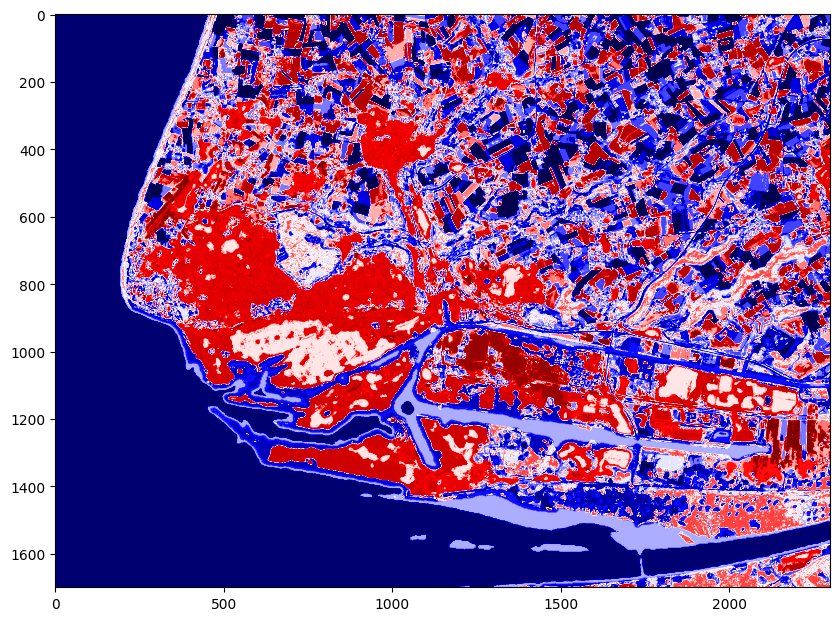

In [14]:
image =create_kmeans_image('dataframe_LH_k20.csv', paths[0])

plt.figure(figsize=(10, 8))
plt.imshow(image, cmap='seismic')

In [15]:
save_as_raster(image, paths[0], 'raster_LH_k20.tif')

Raster created as : raster_LH_k20.tif


In [17]:
df=pd.read_csv('dataframe_LH_k20.csv')
# Sélection des colonnes correspondantes pour le calcul des moyennes
colonnes_temp = df.filter(regex='^temp', axis=1)  # Sélectionne les colonnes commençant par 'temp'
colonnes_FAPAR_PPI = df[['FAPAR_LH.tif', 'PPI_LH.tif']]

# Regrouper par 'labels_kmeans' et calculer les moyennes
resultats_moyennes = pd.concat([df['labels_kmeans'],
                                colonnes_temp.mean(axis=1),  # Moyenne des colonnes commençant par 'temp'
                                colonnes_FAPAR_PPI.mean(axis=1)], axis=1)  # Moyenne de 'FAPAR_Rouen.tif' et 'PPI_Rouen.tif'

resultats_moyennes.columns = ['labels_kmeans', 'moyenne_temp', 'moyenne_veg']  # Renommer les colonnes

# Calcul des moyennes pour chaque 'labels_kmeans'
moyennes_par_label = resultats_moyennes.groupby('labels_kmeans').mean()* 100

# Trier par ordre décroissant selon la moyenne des températures
moyennes_triees = moyennes_par_label.sort_values(by='moyenne_temp', ascending=False)

print(moyennes_triees)

               moyenne_temp  moyenne_veg
labels_kmeans                           
10                89.617693     6.805941
16                76.434544     4.561831
15                74.605649    25.595815
14                72.375963    53.158913
19                65.143387    84.538948
3                 62.233977     7.219610
7                 61.618412    30.195897
11                59.871712    60.379957
18                59.038660    14.944590
17                54.518036    69.604574
4                 53.340904    43.991421
0                 53.158297    10.703906
12                51.586366    90.044916
6                 45.904352    69.187703
2                 44.374261    36.850512
5                 36.835773     5.368470
9                 33.372308    88.153373
13                31.656261    62.118924
8                 13.987838     0.618148
1                  0.471849     0.012964


In [60]:
# Anciens et nouveaux labels
ancien_label = [10, 16, 15, 14, 19, 3, 7, 11, 18, 17, 4, 0, 12, 6, 2, 5, 9, 13, 8, 1]
nouveau_label = [12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 1, 1, 1, 0, 1, 1, 0, 0]

In [59]:
print(len(ancien_label))
print(len(nouveau_label))

20
19


In [61]:


# Supposons que 'df' est votre DataFrame et 'ancien_label' est la colonne contenant les anciens labels
# Création d'une nouvelle colonne 'nouveau_label' basée sur la correspondance entre les anciens et nouveaux labels
df['nouveau_label'] = df['labels_kmeans'].map(dict(zip(ancien_label, nouveau_label)))

# Affichage du DataFrame avec la nouvelle colonne 'nouveau_label'
print(df)

         coord_x  coord_y  temp1_LH.tif  temp2_LH.tif  temp3_LH.tif  \
0              0        0      0.000000      0.000000      0.000000   
1              0        1      0.000000      0.000000      0.000000   
2              0        2      0.000000      0.000000      0.000000   
3              0        3      0.000000      0.000000      0.000000   
4              0        4      0.000000      0.000000      0.000000   
...          ...      ...           ...           ...           ...   
3909995     2299     1695      0.174667      0.267333      0.537667   
3909996     2299     1696      0.160667      0.267333      0.526778   
3909997     2299     1697      0.160667      0.267333      0.526778   
3909998     2299     1698      0.160667      0.251500      0.526778   
3909999     2299     1699      0.148833      0.251500      0.518556   

         temp4_LH.tif  temp5_LH.tif  temp6_LH.tif  temp7_LH.tif  temp8_LH.tif  \
0            0.000000         0.000        0.0000      0.000000   

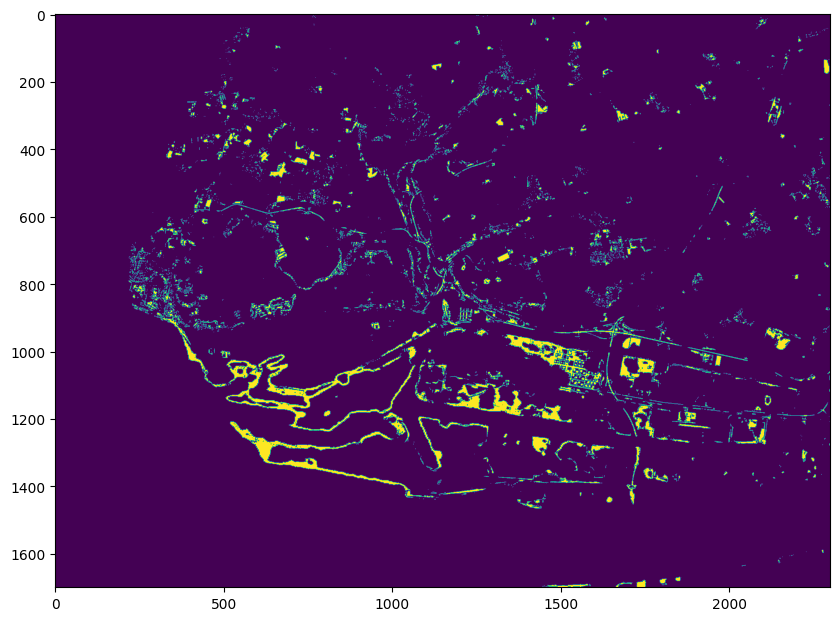

In [42]:
with rasterio.open('raster_LH_k20.tif') as data :
    k20=data.read(1)

    plt.figure(figsize=(10, 8))
    label = 3

    show(k20==label)

In [62]:
df.to_csv('dataframe_LH_k20.csv', index=False)

In [63]:
image1 =create_kmeans_image('dataframe_LH_k20.csv', paths[0])

/tmp/ipykernel_2294/3301945627.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x, y, valeur = row['coord_x'], row['coord_y'], row[-1]


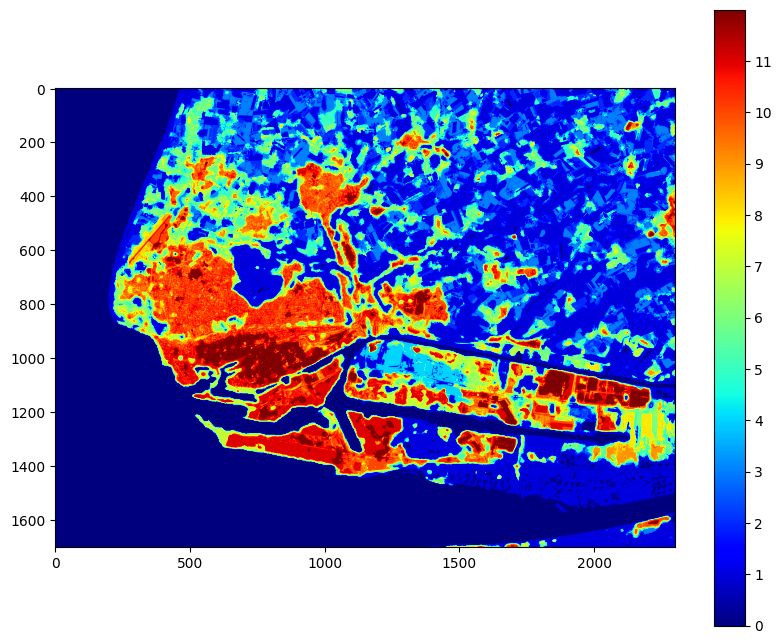

In [64]:
plt.figure(figsize=(10, 8))

plt.imshow(image1, cmap='jet')
plt.colorbar(ticks=np.arange(0, 12))

In [65]:
save_as_raster(image1, paths[0], 'raster_LH_k20.tif')

Raster created as : raster_LH_k20.tif
